# Trader Performance vs Market Sentiment Analysis
## Primetrade.ai Data Science Intern Assignment

**Objective:** Analyze how market sentiment (Fear/Greed) relates to trader behavior and performance on Hyperliquid.


## Setup and Imports

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("Libraries loaded successfully.")


Libraries loaded successfully.


## Part A: Data Preparation

### Step 1: Load Datasets

In [32]:
# Load datasets
sentiment = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")

print("Datasets loaded.\n")

print("Sentiment shape:", sentiment.shape)
print("Trades shape:", trades.shape)


Datasets loaded.

Sentiment shape: (2644, 4)
Trades shape: (211224, 16)


In [33]:
print("===== SENTIMENT DATA =====")
print(sentiment.head())
print("\nColumns:", sentiment.columns)
print("\nInfo:")
print(sentiment.info())

print("\n\n===== TRADES DATA =====")
print(trades.head())
print("\nColumns:", trades.columns)
print("\nInfo:")
print(trades.info())


===== SENTIMENT DATA =====
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05

Columns: Index(['timestamp', 'value', 'classification', 'date'], dtype='object')

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
None


===== TRADES DATA =====
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   


### Check Missing Values + Duplicates

In [34]:
print("===== SENTIMENT CLEANLINESS =====")
print("Missing values:\n", sentiment.isnull().sum())
print("Duplicate rows:", sentiment.duplicated().sum())

print("\n===== TRADES CLEANLINESS =====")
print("Missing values:\n", trades.isnull().sum())
print("Duplicate rows:", trades.duplicated().sum())


===== SENTIMENT CLEANLINESS =====
Missing values:
 timestamp         0
value             0
classification    0
date              0
dtype: int64
Duplicate rows: 0

===== TRADES CLEANLINESS =====
Missing values:
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64
Duplicate rows: 0


### Convert Timestamps & Align by Date

In [35]:
# Convert sentiment date
sentiment['date'] = pd.to_datetime(sentiment['date'])

# Convert trades Timestamp IST to datetime
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], dayfirst=True)

# Create date column for trades (daily level)
trades['date'] = trades['Timestamp IST'].dt.date

# Convert sentiment date to date (daily)
sentiment['date_only'] = sentiment['date'].dt.date

print("Conversion done.\n")

print("Trades date range:", trades['date'].min(), "to", trades['date'].max())
print("Sentiment date range:", sentiment['date_only'].min(), "to", sentiment['date_only'].max())


Conversion done.

Trades date range: 2023-05-01 to 2025-05-01
Sentiment date range: 2018-02-01 to 2025-05-02


### Merge Trades with Sentiment

In [36]:
# Merge datasets on daily date
merged = trades.merge(
    sentiment[['date_only', 'classification']],
    left_on='date',
    right_on='date_only',
    how='left'
)

print("Merge complete.\n")

print("Merged shape:", merged.shape)
print("\nMissing sentiment rows after merge:",
      merged['classification'].isnull().sum())

print("\nSentiment distribution:")
print(merged['classification'].value_counts())


Merge complete.

Merged shape: (211224, 19)

Missing sentiment rows after merge: 6

Sentiment distribution:
classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64


### Final Merge

In [37]:
# Drop rows with missing sentiment
merged = merged.dropna(subset=['classification'])

print("After dropping missing sentiment:", merged.shape)

# Create win column
merged['is_win'] = merged['Closed PnL'] > 0

print("\nWin rate overall:", merged['is_win'].mean())


After dropping missing sentiment: (211218, 19)

Win rate overall: 0.41124809438589516


### Create Core Daily Metrics

In [38]:
# 1️⃣ Daily PnL per trader
daily_pnl = merged.groupby(['Account', 'date'])['Closed PnL'].sum().reset_index()
daily_pnl.rename(columns={'Closed PnL': 'daily_pnl'}, inplace=True)

# 2️⃣ Daily win rate per trader
daily_winrate = merged.groupby(['Account', 'date'])['is_win'].mean().reset_index()
daily_winrate.rename(columns={'is_win': 'daily_win_rate'}, inplace=True)

# 3️⃣ Trades per day per trader
daily_trades = merged.groupby(['Account', 'date']).size().reset_index(name='trades_per_day')

# 4️⃣ Average position size (proxy for leverage/exposure)
daily_size = merged.groupby(['Account', 'date'])['Size USD'].mean().reset_index()
daily_size.rename(columns={'Size USD': 'avg_trade_size'}, inplace=True)

print("Daily metrics created.\n")

print("Daily PnL sample:")
print(daily_pnl.head())

print("\nTotal unique traders:", merged['Account'].nunique())
print("Total trading days:", merged['date'].nunique())


Daily metrics created.

Daily PnL sample:
                                      Account        date   daily_pnl
0  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-11      0.0000
1  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-17      0.0000
2  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-18      0.0000
3  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-22 -21227.0000
4  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-26   1603.1000

Total unique traders: 32
Total trading days: 479


### Attach Sentiment to Daily Metrics

In [39]:
# Get daily sentiment (unique per date)
daily_sentiment = sentiment[['date_only', 'classification']].copy()
daily_sentiment.rename(columns={'date_only': 'date'}, inplace=True)

# Convert date type to match daily_pnl
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date']).dt.date

# Merge sentiment into daily_pnl
daily_pnl = daily_pnl.merge(daily_sentiment, on='date', how='left')

# Also merge into daily_winrate, daily_trades, daily_size
daily_winrate = daily_winrate.merge(daily_sentiment, on='date', how='left')
daily_trades = daily_trades.merge(daily_sentiment, on='date', how='left')
daily_size = daily_size.merge(daily_sentiment, on='date', how='left')

print("Sentiment attached to daily metrics.\n")

print("Daily PnL sample with sentiment:")
print(daily_pnl.head())


Sentiment attached to daily metrics.

Daily PnL sample with sentiment:
                                      Account        date   daily_pnl  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-11      0.0000   
1  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-17      0.0000   
2  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-18      0.0000   
3  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-22 -21227.0000   
4  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-26   1603.1000   

  classification  
0  Extreme Greed  
1  Extreme Greed  
2  Extreme Greed  
3  Extreme Greed  
4  Extreme Greed  


## PART B — CORE ANALYSIS

### Create Binary Sentiment

In [40]:
# Create simplified sentiment column
def simplify_sentiment(x):
    if "Fear" in x:
        return "Fear"
    elif "Greed" in x:
        return "Greed"
    else:
        return "Neutral"

daily_pnl['sentiment_simple'] = daily_pnl['classification'].apply(simplify_sentiment)
daily_winrate['sentiment_simple'] = daily_winrate['classification'].apply(simplify_sentiment)
daily_trades['sentiment_simple'] = daily_trades['classification'].apply(simplify_sentiment)
daily_size['sentiment_simple'] = daily_size['classification'].apply(simplify_sentiment)

print(daily_pnl['sentiment_simple'].value_counts())


sentiment_simple
Greed      1174
Fear        790
Neutral     376
Name: count, dtype: int64


### Compare Performance: Fear vs Greed

In [41]:
# 1️⃣ Average Daily PnL
pnl_comparison = daily_pnl.groupby('sentiment_simple')['daily_pnl'].mean()

# 2️⃣ Median Daily PnL (more robust)
median_pnl = daily_pnl.groupby('sentiment_simple')['daily_pnl'].median()

# 3️⃣ Average Daily Win Rate
winrate_comparison = daily_winrate.groupby('sentiment_simple')['daily_win_rate'].mean()

# 4️⃣ Avg Trades Per Day
trades_comparison = daily_trades.groupby('sentiment_simple')['trades_per_day'].mean()

# 5️⃣ Avg Trade Size
size_comparison = daily_size.groupby('sentiment_simple')['avg_trade_size'].mean()

print("=== Average Daily PnL ===")
print(pnl_comparison)

print("\n=== Median Daily PnL ===")
print(median_pnl)

print("\n=== Average Daily Win Rate ===")
print(winrate_comparison)

print("\n=== Avg Trades Per Day ===")
print(trades_comparison)

print("\n=== Avg Trade Size ===")
print(size_comparison)


=== Average Daily PnL ===
sentiment_simple
Fear      5185.1464
Greed     4144.2083
Neutral   3438.6188
Name: daily_pnl, dtype: float64

=== Median Daily PnL ===
sentiment_simple
Fear      122.7370
Greed     265.2477
Neutral   167.5517
Name: daily_pnl, dtype: float64

=== Average Daily Win Rate ===
sentiment_simple
Fear      0.3571
Greed     0.3627
Neutral   0.3554
Name: daily_win_rate, dtype: float64

=== Avg Trades Per Day ===
sentiment_simple
Fear      105.3633
Greed      76.9123
Neutral   100.2287
Name: trades_per_day, dtype: float64

=== Avg Trade Size ===
sentiment_simple
Fear      8529.8598
Greed     5954.6326
Neutral   6963.6949
Name: avg_trade_size, dtype: float64


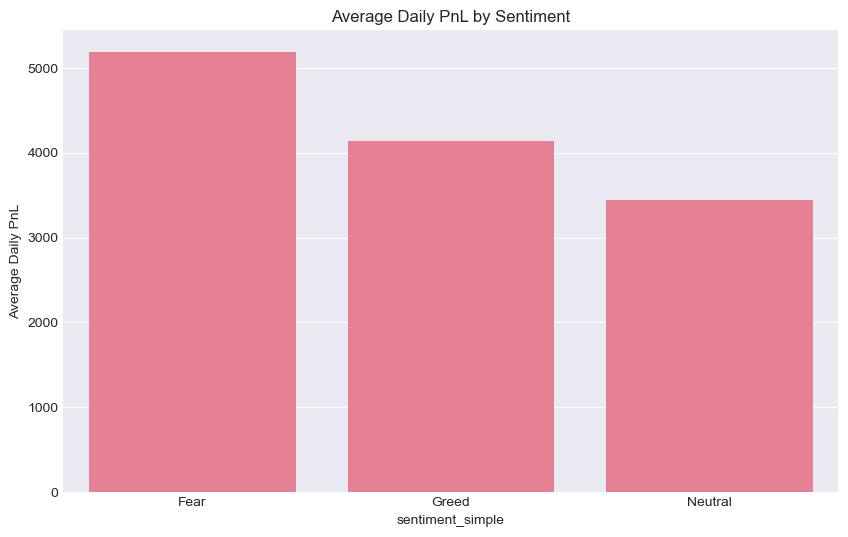

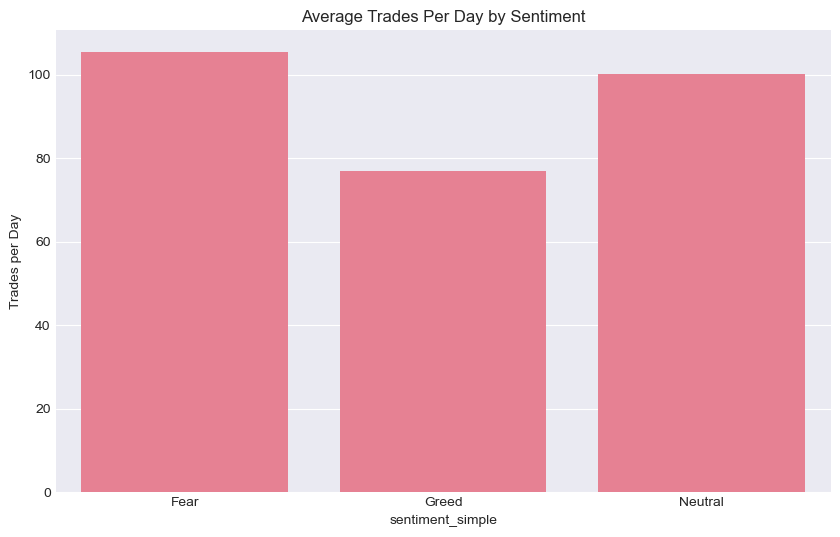

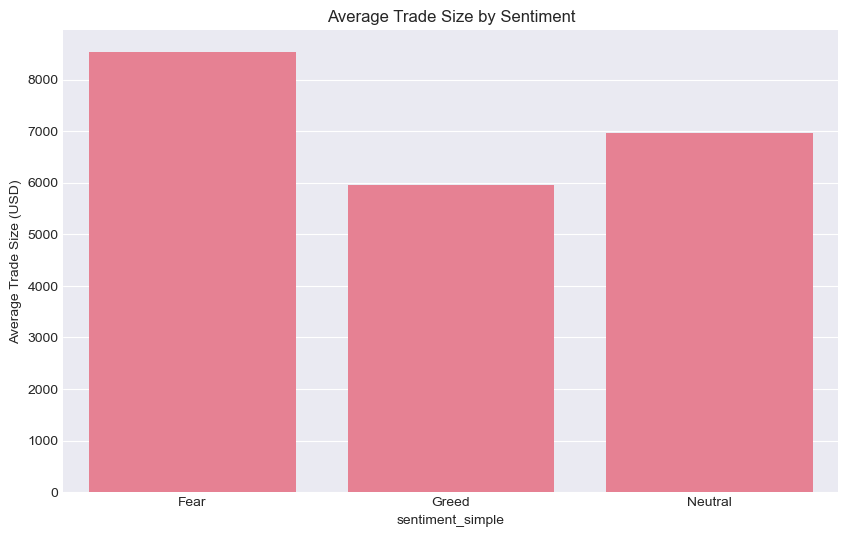

In [42]:
plt.figure(figsize=(10,6))
sns.barplot(x=pnl_comparison.index, y=pnl_comparison.values)
plt.title("Average Daily PnL by Sentiment")
plt.ylabel("Average Daily PnL")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x=trades_comparison.index, y=trades_comparison.values)
plt.title("Average Trades Per Day by Sentiment")
plt.ylabel("Trades per Day")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x=size_comparison.index, y=size_comparison.values)
plt.title("Average Trade Size by Sentiment")
plt.ylabel("Average Trade Size (USD)")
plt.show()


### Volatility

In [43]:
# PnL volatility (risk proxy)
volatility = daily_pnl.groupby('sentiment_simple')['daily_pnl'].std()

print("=== Daily PnL Volatility (Std Dev) ===")
print(volatility)


=== Daily PnL Volatility (Std Dev) ===
sentiment_simple
Fear      31224.1488
Greed     29252.0377
Neutral   17447.8636
Name: daily_pnl, dtype: float64


### Segment Traders by Activity Level

In [44]:
# Total trades per trader
trader_activity = merged.groupby('Account').size().reset_index(name='total_trades')

# Determine threshold (top 30% = high activity)
threshold = trader_activity['total_trades'].quantile(0.7)

trader_activity['activity_segment'] = np.where(
    trader_activity['total_trades'] >= threshold,
    'High Activity',
    'Low Activity'
)

print("Activity threshold:", threshold)
print(trader_activity['activity_segment'].value_counts())


Activity threshold: 7492.8
activity_segment
Low Activity     22
High Activity    10
Name: count, dtype: int64


In [45]:
# Merge activity segment into daily_pnl
daily_pnl = daily_pnl.merge(
    trader_activity[['Account', 'activity_segment']],
    on='Account',
    how='left'
)

daily_winrate = daily_winrate.merge(
    trader_activity[['Account', 'activity_segment']],
    on='Account',
    how='left'
)

daily_trades = daily_trades.merge(
    trader_activity[['Account', 'activity_segment']],
    on='Account',
    how='left'
)

daily_size = daily_size.merge(
    trader_activity[['Account', 'activity_segment']],
    on='Account',
    how='left'
)

print("Segment merged successfully.")
print(daily_pnl[['Account','activity_segment']].drop_duplicates().head())


Segment merged successfully.
                                        Account activity_segment
0    0x083384f897ee0f19899168e3b1bec365f52a9012     Low Activity
24   0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd     Low Activity
76   0x271b280974205ca63b716753467d5a371de622ab     Low Activity
88   0x28736f43f1e871e6aa8b1148d38d4994275d72c4    High Activity
250  0x2c229d22b100a7beb69122eed721cee9b24011dd     Low Activity


In [46]:
# Average daily PnL by activity + sentiment
segment_pnl = daily_pnl.groupby(
    ['activity_segment', 'sentiment_simple']
)['daily_pnl'].mean().reset_index()

print("=== Avg Daily PnL by Segment & Sentiment ===")
print(segment_pnl)

# Average win rate
segment_winrate = daily_winrate.groupby(
    ['activity_segment', 'sentiment_simple']
)['daily_win_rate'].mean().reset_index()

print("\n=== Avg Win Rate by Segment & Sentiment ===")
print(segment_winrate)

# Avg trades per day
segment_trades = daily_trades.groupby(
    ['activity_segment', 'sentiment_simple']
)['trades_per_day'].mean().reset_index()

print("\n=== Avg Trades Per Day by Segment & Sentiment ===")
print(segment_trades)


=== Avg Daily PnL by Segment & Sentiment ===
  activity_segment sentiment_simple  daily_pnl
0    High Activity             Fear  3455.9708
1    High Activity            Greed  4344.6315
2    High Activity          Neutral  3764.5511
3     Low Activity             Fear  7314.8655
4     Low Activity            Greed  3744.3846
5     Low Activity          Neutral  2814.5470

=== Avg Win Rate by Segment & Sentiment ===
  activity_segment sentiment_simple  daily_win_rate
0    High Activity             Fear          0.3622
1    High Activity            Greed          0.3768
2    High Activity          Neutral          0.3902
3     Low Activity             Fear          0.3508
4     Low Activity            Greed          0.3348
5     Low Activity          Neutral          0.2888

=== Avg Trades Per Day by Segment & Sentiment ===
  activity_segment sentiment_simple  trades_per_day
0    High Activity             Fear        129.2890
1    High Activity            Greed         91.5857
2    High 

# Actionable Strategy Recommendations

Strategy 1 — Sentiment-Adaptive Capital Allocation

Observation:

Low Activity traders generate significantly higher average PnL during Fear periods.

High Activity traders perform better during Greed periods.

Fear periods are associated with higher volatility and larger position sizing.

Rule of Thumb:

During Fear days:

Allocate relatively more capital to Low Activity traders.

Impose tighter risk controls due to higher volatility.

Expect higher dispersion in returns.

During Greed days:

Allocate relatively more capital to High Activity traders.

Allow systematic scaling strategies in trending environments.

Focus on consistency over volatility capture.

Rationale:
Trader performance is sentiment-dependent. Aligning capital deployment with trader behavioral strengths improves risk-adjusted returns.

 Strategy 2 — Dynamic Risk & Exposure Adjustment

Observation:

Traders increase trade frequency and average trade size during Fear periods.

Win rate remains relatively stable across sentiment regimes (~36%).

Higher mean PnL during Fear is driven by increased exposure rather than improved predictive accuracy.

Rule of Thumb:

During Fear days:

Reduce maximum allowed position size per trade.

Introduce volatility-based exposure caps.

Monitor drawdown risk more aggressively.

During Greed days:

Encourage disciplined scaling.

Allow higher trade counts for High Activity traders.

Focus on trend-following strategies rather than volatility capture.

Rationale:
Since performance improvements during Fear are driven by increased risk-taking rather than improved win probability, controlling exposure improves long-term capital stability.

Expected Impact

Implementing sentiment-aware allocation and exposure control can:

Improve capital efficiency

Reduce tail risk during high-volatility periods

Align trader behavior with prevailing market regimes

Enhance risk-adjusted portfolio performance

## Bonus

In [47]:
# Sort properly
daily_pnl = daily_pnl.sort_values(['Account', 'date'])

# Create next-day pnl per trader
daily_pnl['next_day_pnl'] = daily_pnl.groupby('Account')['daily_pnl'].shift(-1)

# Create profitability bucket (1 = profitable, 0 = not)
daily_pnl['next_day_profitable'] = (daily_pnl['next_day_pnl'] > 0).astype(int)

print(daily_pnl[['Account','date','daily_pnl','next_day_pnl','next_day_profitable']].head(10))


                                      Account        date    daily_pnl  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-11       0.0000   
1  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-17       0.0000   
2  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-18       0.0000   
3  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-22  -21227.0000   
4  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-26    1603.1000   
5  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-28 -132271.0000   
6  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-30       0.0000   
7  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-12-06 -175611.0001   
8  0x083384f897ee0f19899168e3b1bec365f52a9012  2025-01-19   71393.9641   
9  0x083384f897ee0f19899168e3b1bec365f52a9012  2025-01-20   40218.6000   

   next_day_pnl  next_day_profitable  
0        0.0000                    0  
1        0.0000                    0  
2   -21227.0000                    0  
3     1603.1000              

In [48]:
# Start from daily_pnl
model_df = daily_pnl.copy()

# Merge features
model_df = model_df.merge(
    daily_winrate[['Account','date','daily_win_rate']],
    on=['Account','date'],
    how='left'
)

model_df = model_df.merge(
    daily_trades[['Account','date','trades_per_day']],
    on=['Account','date'],
    how='left'
)

model_df = model_df.merge(
    daily_size[['Account','date','avg_trade_size']],
    on=['Account','date'],
    how='left'
)

# Drop last day rows where next_day_pnl is NaN
model_df = model_df.dropna(subset=['next_day_pnl'])

print("Model dataset shape:", model_df.shape)
print(model_df.head())


Model dataset shape: (2308, 11)
                                      Account        date   daily_pnl  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-11      0.0000   
1  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-17      0.0000   
2  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-18      0.0000   
3  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-22 -21227.0000   
4  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-26   1603.1000   

  classification sentiment_simple activity_segment  next_day_pnl  \
0  Extreme Greed            Greed     Low Activity        0.0000   
1  Extreme Greed            Greed     Low Activity        0.0000   
2  Extreme Greed            Greed     Low Activity   -21227.0000   
3  Extreme Greed            Greed     Low Activity     1603.1000   
4  Extreme Greed            Greed     Low Activity  -132271.0000   

   next_day_profitable  daily_win_rate  trades_per_day  avg_trade_size  
0                    0          0.0000         

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Select features
features = [
    'daily_win_rate',
    'trades_per_day',
    'avg_trade_size',
    'sentiment_simple',
    'activity_segment'
]

X = model_df[features]
y = model_df['next_day_profitable']

# One-hot encode categorical variables
X = pd.get_dummies(X, columns=['sentiment_simple', 'activity_segment'], drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.683982683982684

Classification Report:

              precision    recall  f1-score   support

           0       0.63      0.39      0.48       174
           1       0.70      0.86      0.77       288

    accuracy                           0.68       462
   macro avg       0.67      0.63      0.63       462
weighted avg       0.67      0.68      0.66       462

